In [1]:
import os
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from get_data.traj_generator import (
  derive_target_velocities,
  derive_target_accelerations
)

CTRL_FREQ  = 30
SEGMENTS   = 4
TOTAL_TIME = 12

/var/folders/q3/0mld71gj36v0xnwbht7h83l00000gn/T/ipykernel_44327/719767929.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


0.0066928509242848554 0.9525741268224334


pybullet build time: Oct 21 2023 23:43:02


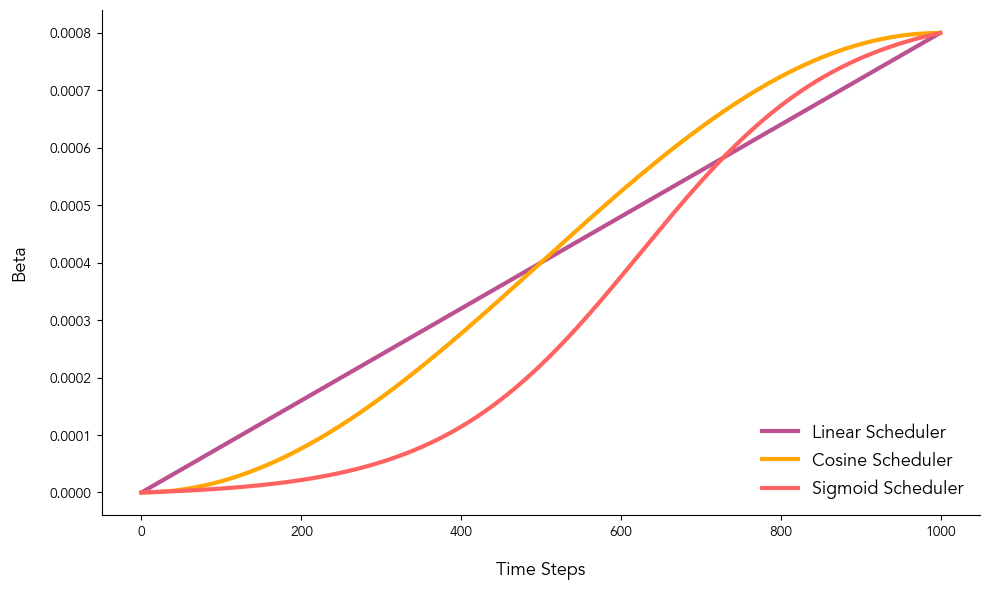

In [2]:
from models.schedulers import LinearScheduler, CosineScheduler, SigmoidScheduler
from get_data.plotting_utils import ColorPalletteOne as ColorPallette

T            = 1000
beta_linear  = LinearScheduler(T).beta
beta_cos     = CosineScheduler(T).beta
beta_sigmoid = SigmoidScheduler(T).beta

plt.rcParams['font.family'] = 'Avenir'
# Create a single plot for all the schedulers
fig, ax = plt.subplots(figsize=(10, 6))

WEIGHT = 3

# Plot each scheduler on the same graph with thicker lines
ax.plot(beta_linear, label='Linear Scheduler', linewidth=WEIGHT, color=ColorPallette.C)
ax.plot(beta_cos, label='Cosine Scheduler', linewidth=WEIGHT, color=ColorPallette.E)
ax.plot(beta_sigmoid, label='Sigmoid Scheduler', linewidth=WEIGHT, color=ColorPallette.D)

# Set labels and title
# ax.set_title('Scheduler Comparison')
ax.set_xlabel('Time Steps', labelpad=15, fontsize=13)
ax.set_ylabel('Beta', labelpad=15, fontsize=13)

# Remove the top and right spines (box around the plot)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the legend
ax.legend(
    loc='lower right',          # Position the legend in the upper right corner
    frameon=False,               # Add a frame around the legend
    fontsize=13
)


# Show the plot
plt.tight_layout()
plt.show()


In [3]:
def get_stats_for_trajectory(ref_pos):
  ref_vel = derive_target_velocities(ref_pos, CTRL_FREQ)
  ref_acc = derive_target_accelerations(ref_vel, CTRL_FREQ)
  
  mean_vel   = np.mean(np.linalg.norm(ref_vel, axis=1))
  mean_accel = np.mean(np.linalg.norm(ref_acc, axis=1))
  
  # Compute angle between each change in position vector
  angles      = []
  differences = np.diff(ref_pos, axis=0)
  differences /= np.linalg.norm(differences, axis=1, keepdims=True)
    
  for idx in range(differences.shape[0] - 1):
    v1, v2 = differences[idx], differences[idx + 1]
    angle  = np.arccos(v1.dot(v2)) * 180 / np.pi
    angles.append(angle)
    
  return {
    "mean_vel": mean_vel,
    "mean_accel": mean_accel,
    "theta_spread": np.std(angles)
  }

In [4]:
data_dir = 'data'

stats_list = []
for filename in tqdm.tqdm(os.listdir(data_dir)):
    if filename.endswith('.npy'):  # Process only .npy files
        filepath = os.path.join(data_dir, filename)        
        ref_pos  = np.load(filepath)
        stats    = get_stats_for_trajectory(ref_pos)
        stats['sample'] = filename.replace('.npy', '')
        stats_list.append(stats)

# Convert the list of stats dictionaries to a DataFrame
df = pd.DataFrame(stats_list)

100%|██████████| 18715/18715 [00:11<00:00, 1653.66it/s]


Data of 4 segment 12s trajectories with 18715 samples


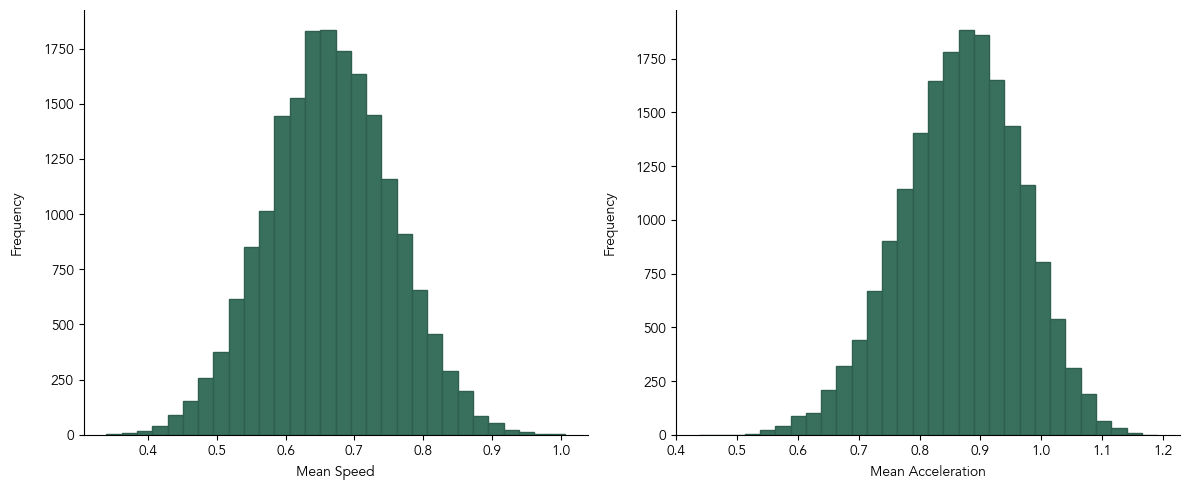

In [5]:
from get_data.plotting_utils import ColorPalletteFour as ColorPallette

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.rcParams['font.family'] = 'Avenir'
titles = ['Mean Speed', 'Mean Acceleration', 'Agility Required']

axs[0].hist(df['mean_vel'], bins=30, color=ColorPallette.B, edgecolor=ColorPallette.C)
axs[0].set_xlabel('Mean Speed')
axs[0].set_ylabel('Frequency', labelpad=13)

axs[1].hist(df['mean_accel'], bins=30, color=ColorPallette.B, edgecolor=ColorPallette.C)
axs[1].set_xlabel('Mean Acceleration')
axs[1].set_ylabel('Frequency', labelpad=13)

for ax in axs:
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

print(f'Data of 4 segment 12s trajectories with {df.shape[0]} samples')
plt.tight_layout()
plt.show()

In [6]:
max_vel_row = df.loc[df['mean_vel'].idxmax()]
min_vel_row = df.loc[df['mean_vel'].idxmin()]

max_accel_row = df.loc[df['mean_accel'].idxmax()]
min_accel_row = df.loc[df['mean_accel'].idxmin()]

max_theta_spread_row = df.loc[df['theta_spread'].idxmax()]
min_theta_spread_row = df.loc[df['theta_spread'].idxmin()]

print("Row with Maximum Velocity:")
print(max_vel_row)
print("\nRow with Minimum Velocity:")
print(min_vel_row)

print("\nRow with Maximum Acceleration:")
print(max_accel_row)
print("\nRow with Minimum Acceleration:")
print(min_accel_row)

print("\nRow with Maximum Theta Spread:")
print(max_theta_spread_row)
print("\nRow with Minimum Theta Spread:")
print(min_theta_spread_row)

Row with Maximum Velocity:
mean_vel        1.005346
mean_accel      1.043714
theta_spread      1.2831
sample             18130
Name: 14984, dtype: object

Row with Minimum Velocity:
mean_vel        0.339477
mean_accel      0.655059
theta_spread    4.929974
sample              5533
Name: 10552, dtype: object

Row with Maximum Acceleration:
mean_vel        0.761515
mean_accel      1.190093
theta_spread    3.649104
sample             10824
Name: 3944, dtype: object

Row with Minimum Acceleration:
mean_vel        0.366117
mean_accel      0.437532
theta_spread    1.552656
sample             13543
Name: 5769, dtype: object

Row with Maximum Theta Spread:
mean_vel        0.615053
mean_accel      0.917052
theta_spread    9.331303
sample             17457
Name: 8563, dtype: object

Row with Minimum Theta Spread:
mean_vel        0.833047
mean_accel      0.694111
theta_spread    0.602276
sample              4682
Name: 3490, dtype: object
